In [1]:
import pandas as pd

# Load the dataset
file_path = "/workspaces/Music-recommender/user_song_table.csv"
data = pd.read_csv(file_path)

# Display the column names and first few rows
print("Column names:", data.columns)
print(data.head())


Column names: Index(['user_id', 'blues.00000.0.wav', 'blues.00000.1.wav',
       'blues.00000.2.wav', 'blues.00000.3.wav', 'blues.00000.4.wav',
       'blues.00000.5.wav', 'blues.00000.6.wav', 'blues.00000.7.wav',
       'blues.00000.8.wav',
       ...
       'rock.00099.0.wav', 'rock.00099.1.wav', 'rock.00099.2.wav',
       'rock.00099.3.wav', 'rock.00099.4.wav', 'rock.00099.5.wav',
       'rock.00099.6.wav', 'rock.00099.7.wav', 'rock.00099.8.wav',
       'rock.00099.9.wav'],
      dtype='object', length=9991)
  user_id  blues.00000.0.wav  blues.00000.1.wav  blues.00000.2.wav  \
0  user_0                  0                  0                  0   
1  user_1                  0                  0                  0   
2  user_2                  0                  0                  0   
3  user_3                  0                  0                  0   
4  user_4                  0                  0                  0   

   blues.00000.3.wav  blues.00000.4.wav  blues.00000.5.wav  bl

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random

# Load the dataset
file_path = "/workspaces/Music-recommender/user_song_table.csv"
data = pd.read_csv(file_path)

# Extract track data (excluding 'user_id')
track_data = data.drop(columns=['user_id'])

# Compute song similarity
song_similarity = cosine_similarity(track_data.T)  # Transpose to calculate similarity between tracks

# Cluster songs using KMeans
num_clusters = 300  # Number of playlists
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
song_clusters = kmeans.fit_predict(song_similarity)

# Map songs to clusters
tracks = track_data.columns
clustered_songs = pd.DataFrame({'track': tracks, 'cluster': song_clusters})

# Create playlists
playlists = {}
for cluster in range(num_clusters):
    # Get tracks in the cluster
    cluster_tracks = clustered_songs[clustered_songs['cluster'] == cluster]['track'].tolist()
    # Randomly sample 12 tracks if there are more than 12
    playlist = random.sample(cluster_tracks, min(len(cluster_tracks), 12))
    playlists[f"Playlist_{cluster+1}"] = playlist

# Save playlists to a file
output_path = "/workspaces/Music-recommender/playlists.csv"
playlists_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in playlists.items()]))
playlists_df.to_csv(output_path, index=False)

print(f"Playlists have been saved to {output_path}")


In [4]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/workspaces/Music-recommender/user_song_table.csv"
data = pd.read_csv(file_path)

# Extract track data (excluding 'user_id')
track_data = data.drop(columns=['user_id'])
user_ids = data['user_id']

# Load playlists (created earlier)
playlists_path = "/workspaces/Music-recommender/playlists.csv"
playlists_df = pd.read_csv(playlists_path)

# Initialize the Playlist X User matrix
playlist_user_matrix = pd.DataFrame(0, index=playlists_df.columns, columns=user_ids)

# Fill the matrix
for playlist in playlists_df.columns:
    playlist_tracks = playlists_df[playlist].dropna().tolist()  # Get tracks in the playlist
    for user_index, user_id in enumerate(user_ids):
        user_tracks = track_data.iloc[user_index]  # Tracks for the current user
        for order, track in enumerate(playlist_tracks, start=1):
            if track in user_tracks.index and user_tracks[track] > 0:
                playlist_user_matrix.loc[playlist, user_id] = order
                break  # Assign the first matching track's order

# Save the Playlist X User matrix
output_path = "/workspaces/Music-recommender/playlist_user_matrix.csv"
playlist_user_matrix.to_csv(output_path, index=True)

print(f"Playlist X User matrix has been saved to {output_path}")


Playlist X User matrix has been saved to /workspaces/Music-recommender/playlist_user_matrix.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dot, Add
from tensorflow.keras.optimizers import Adam

# Load the Playlist x Track matrix
matrix_path = "/workspaces/Music-recommender/playlist_user_matrix.csv"
matrix_df = pd.read_csv(matrix_path, index_col=0)
matrix = matrix_df.fillna(0).values  # Replace NaNs with 0

# Prepare data for DMF
num_playlists, num_tracks = matrix.shape
playlist_ids, track_ids = np.where(matrix > 0)  # Indices of non-zero ratings
ratings = matrix[playlist_ids, track_ids]  # Corresponding ratings

# Normalize ratings
ratings = (ratings - np.min(ratings)) / (np.max(ratings) - np.min(ratings))

# Split data into training and testing sets
train_playlist, test_playlist, train_track, test_track, train_ratings, test_ratings = train_test_split(
    playlist_ids, track_ids, ratings, test_size=0.2, random_state=42
)

# Define the DMF model
embedding_dim = 50

# Playlist branch
playlist_input = Input(shape=(1,))
playlist_embedding = Embedding(num_playlists, embedding_dim)(playlist_input)
playlist_vec = Flatten()(playlist_embedding)

# Track branch
track_input = Input(shape=(1,))
track_embedding = Embedding(num_tracks, embedding_dim)(track_input)
track_vec = Flatten()(track_embedding)

# Merge branches
dot_product = Dot(axes=1)([playlist_vec, track_vec])
output = Dense(1, activation='sigmoid')(dot_product)

# Compile model
model = Model(inputs=[playlist_input, track_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train model
history = model.fit(
    [train_playlist, train_track],
    train_ratings,
    validation_data=([test_playlist, test_track], test_ratings),
    epochs=13,
    batch_size=256,
    verbose=1
)
# Predict missing ratings
predicted_ratings = np.zeros_like(matrix, dtype=np.float32)

for playlist in range(num_playlists):
    for track in range(num_tracks):
        # Convert inputs to NumPy arrays
        predicted_ratings[playlist, track] = model.predict(
            [np.array([playlist]), np.array([track])]
        )[0][0]

# Generate recommendations
recommendations = {}
for playlist_id, playlist_name in enumerate(matrix_df.index):
    track_scores = predicted_ratings[playlist_id]
    recommended_tracks = np.argsort(-track_scores)[:10]  # Top 10 tracks
    recommendations[playlist_name] = [matrix_df.columns[track] for track in recommended_tracks]

# Save recommendations
recommendations_path = "/workspaces/Music-recommender/playlist_recommendations.csv"
recommendations_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in recommendations.items()]))
recommendations_df.to_csv(recommendations_path, index=False)

print(f"Recommendations have been saved to {recommendations_path}")



Epoch 1/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.1433 - mae: 0.3387 - val_loss: 0.1498 - val_mae: 0.3484
Epoch 2/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1425 - mae: 0.3362 - val_loss: 0.1494 - val_mae: 0.3479
Epoch 3/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1445 - mae: 0.3408 - val_loss: 0.1490 - val_mae: 0.3475
Epoch 4/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1413 - mae: 0.3361 - val_loss: 0.1486 - val_mae: 0.3470
Epoch 5/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1392 - mae: 0.3329 - val_loss: 0.1482 - val_mae: 0.3466
Epoch 6/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1391 - mae: 0.3333 - val_loss: 0.1478 - val_mae: 0.3462
Epoch 7/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1358 - mae: 0.3280 - val_loss: 0.1474 - val_mae: 0.3457
Epoch 8/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1363 - mae: 0.3293 - val_loss: 0.1470 - val_mae: 0.3453
Epoch 9/13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1327 - mae: 0.3241 -

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load the Playlist x Track matrix
matrix_path = "/workspaces/Music-recommender/playlist_user_matrix.csv"
matrix_df = pd.read_csv(matrix_path, index_col=0)
matrix = matrix_df.fillna(0).values.astype(np.float32)  # Use float32 for memory efficiency

# Prepare data for DMF
num_playlists, num_tracks = matrix.shape
playlist_ids, track_ids = np.nonzero(matrix)  # More efficient than np.where
ratings = matrix[playlist_ids, track_ids]

# Normalize ratings
ratings = (ratings - ratings.min()) / (ratings.max() - ratings.min())

# Split data into training and testing sets
train_playlist, test_playlist, train_track, test_track, train_ratings, test_ratings = train_test_split(
    playlist_ids, track_ids, ratings, test_size=0.2, random_state=42
)

# Define the DMF model
embedding_dim = 32  # Reduced dimension for faster training
playlist_input = Input(shape=(1,))
playlist_embedding = Embedding(num_playlists, embedding_dim)(playlist_input)
playlist_vec = Flatten()(playlist_embedding)

track_input = Input(shape=(1,))
track_embedding = Embedding(num_tracks, embedding_dim)(track_input)
track_vec = Flatten()(track_embedding)

dot_product = Dot(axes=1)([playlist_vec, track_vec])
output = Dense(1, activation='sigmoid')(dot_product)

# Compile model
model = Model(inputs=[playlist_input, track_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with larger batch size
history = model.fit(
    [train_playlist, train_track],
    train_ratings,
    validation_data=([test_playlist, test_track], test_ratings),
    epochs=13,
    batch_size=1024,  # Increased batch size
    callbacks=[early_stopping],
    verbose=1
)

# Efficient batch prediction
def predict_in_batches(model, num_playlists, num_tracks, batch_size=1024):
    predicted_ratings = np.zeros((num_playlists, num_tracks), dtype=np.float32)
    
    for i in range(0, num_playlists, batch_size):
        batch_end = min(i + batch_size, num_playlists)
        playlist_batch = np.arange(i, batch_end)
        
        # Create meshgrid for current batch
        playlist_matrix, track_matrix = np.meshgrid(
            playlist_batch,
            np.arange(num_tracks)
        )
        
        # Reshape for prediction
        batch_predictions = model.predict(
            [playlist_matrix.T.flatten(), track_matrix.T.flatten()],
            batch_size=batch_size,
            verbose=0
        )
        
        predicted_ratings[i:batch_end] = batch_predictions.reshape(-1, num_tracks)
    
    return predicted_ratings

# Generate predictions efficiently
print("Generating predictions...")
predicted_ratings = predict_in_batches(model, num_playlists, num_tracks)

# Generate recommendations efficiently using numpy operations
recommendations = {}
for playlist_id, playlist_name in enumerate(matrix_df.index):
    track_scores = predicted_ratings[playlist_id]
    # Use argpartition instead of argsort for better performance
    top_indices = np.argpartition(-track_scores, 10)[:10]
    recommendations[playlist_name] = [matrix_df.columns[idx] for idx in top_indices]

# Save recommendations
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.to_csv("/workspaces/Music-recommender/playlist_recommendations.csv", index=False)
print("Recommendations have been saved!")

2024-12-28 17:04:00.358967: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 17:04:00.374006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 17:04:00.757846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 17:04:00.885440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735405441.185616    2169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735405441.27

Epoch 1/13


2024-12-28 17:04:06.259845: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - loss: 0.1434 - mae: 0.3382

2024-12-28 17:04:07.294097: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1434 - mae: 0.3382 - val_loss: 0.1501 - val_mae: 0.3487
Epoch 2/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1433 - mae: 0.3381 - val_loss: 0.1500 - val_mae: 0.3486
Epoch 3/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1432 - mae: 0.3380 - val_loss: 0.1499 - val_mae: 0.3485
Epoch 4/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1431 - mae: 0.3379 - val_loss: 0.1498 - val_mae: 0.3484
Epoch 5/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1430 - mae: 0.3378 - val_loss: 0.1497 - val_mae: 0.3483
Epoch 6/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1429 - mae: 0.3377 - val_loss: 0.1496 - val_mae: 0.3482
Epoch 7/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1428 - mae: 0.3376 - val_loss: 0.1495 - val_mae: 0.3481
Epoch 8/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1427 - mae: 0.3375 - val_loss: 0.1494 - val_mae: 0.3480
Epoch 9/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1426 - mae: 0.3374 - val_loss: 

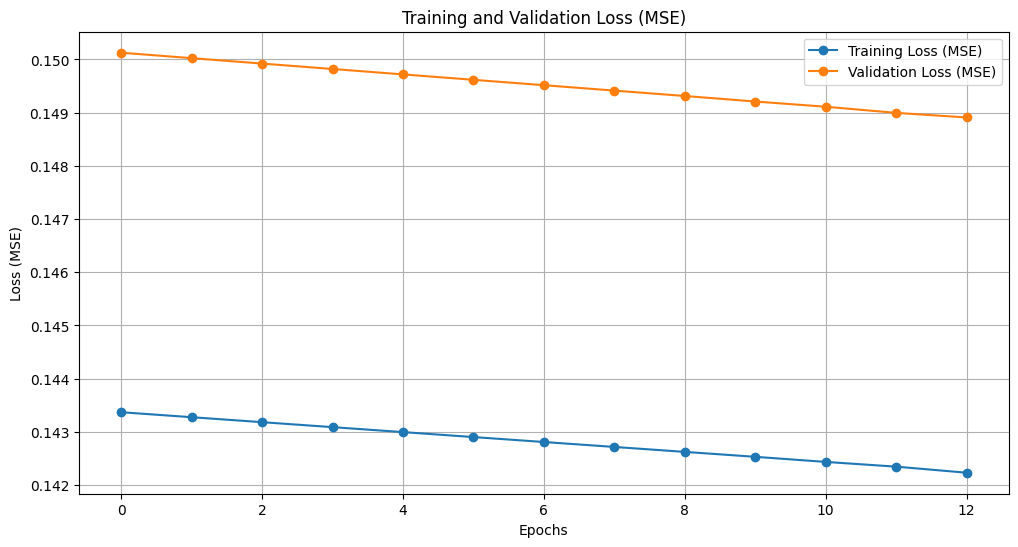

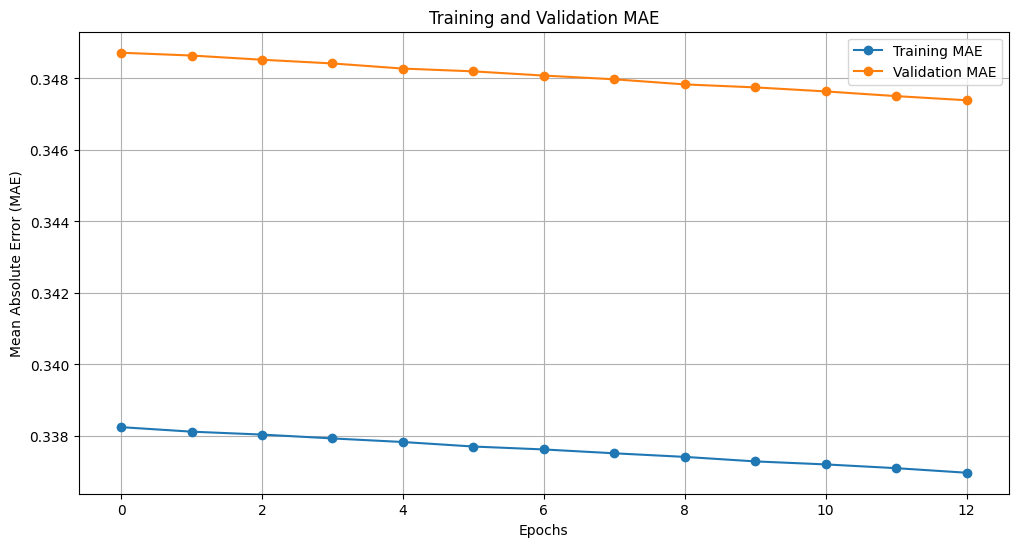

In [7]:
import matplotlib.pyplot as plt

# Extract MSE (loss) and MAE from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot the loss curve (MSE)
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss (MSE)', marker='o')
plt.plot(val_loss, label='Validation Loss (MSE)', marker='o')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the MAE curve
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE', marker='o')
plt.plot(val_mae, label='Validation MAE', marker='o')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import sys

def load_data():
    """Load the necessary data files"""
    try:
        # Load user-song matrix
        matrix_path = "/workspaces/Music-recommender/playlist_user_matrix.csv"
        matrix_df = pd.read_csv(matrix_path, index_col=0)
        
        # Load existing playlists
        playlists_path = "/workspaces/Music-recommender/playlists.csv"
        playlists_df = pd.read_csv(playlists_path)
        
        return matrix_df, playlists_df
    except FileNotFoundError as e:
        print(f"Error: Could not find data files - {str(e)}")
        sys.exit(1)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        sys.exit(1)

def get_user_recommendations(user_id, matrix_df, playlists_df, top_n=5):
    """Get playlist recommendations for a specific user"""
    try:
        # Check if user exists
        if user_id not in matrix_df.columns:
            print(f"Error: User '{user_id}' not found in the database")
            return None
            
        # Get user's playlist ratings
        user_ratings = matrix_df[user_id]
        
        # Sort playlists by rating
        top_playlists = user_ratings.sort_values(ascending=False)[:top_n]
        
        recommendations = []
        for playlist_name, score in top_playlists.items():
            if score > 0:  # Only include positively rated playlists
                playlist_tracks = playlists_df[playlist_name].dropna().tolist()
                
                recommendation = {
                    'playlist_name': playlist_name,
                    'score': score,
                    'num_tracks': len(playlist_tracks),
                    'tracks': playlist_tracks
                }
                recommendations.append(recommendation)
        
        return recommendations
    
    except Exception as e:
        print(f"Error generating recommendations: {str(e)}")
        return None

def display_recommendations(recommendations):
    """Display recommendations in a formatted way"""
    if not recommendations:
        return
        
    print("\n=== Playlist Recommendations ===\n")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"Recommendation #{i}:")
        print(f"Playlist: {rec['playlist_name']}")
        print(f"Match Score: {rec['score']:.2f}")
        print(f"Number of Tracks: {rec['num_tracks']}")
        print("\nTracks:")
        for j, track in enumerate(rec['tracks'], 1):
            print(f"  {j}. {track}")
        print("\n" + "-"*50 + "\n")

def main():
    # Load data
    print("Loading data...")
    matrix_df, playlists_df = load_data()
    
    # Get user input
    print("\nAvailable users:", ', '.join(matrix_df.columns[:5]) + "...")
    user_id = input("\nEnter user ID (e.g., user_0): ").strip()
    
    # Get recommendations
    print("\nGenerating recommendations...")
    recommendations = get_user_recommendations(user_id, matrix_df, playlists_df)
    
    if recommendations:
        display_recommendations(recommendations)
    else:
        print("Could not generate recommendations.")

if __name__ == "__main__":
    main()

Loading data...

Available users: user_0, user_1, user_2, user_3, user_4...

Generating recommendations...

=== Playlist Recommendations ===

Recommendation #1:
Playlist: Playlist_51
Match Score: 12.00
Number of Tracks: 12

Tracks:
  1. country.00053.4.wav
  2. metal.00028.9.wav
  3. metal.00019.0.wav
  4. rock.00094.7.wav
  5. disco.00079.9.wav
  6. metal.00034.4.wav
  7. blues.00083.9.wav
  8. metal.00092.9.wav
  9. metal.00040.2.wav
  10. rock.00065.8.wav
  11. rock.00017.4.wav
  12. metal.00040.5.wav

--------------------------------------------------

Recommendation #2:
Playlist: Playlist_7
Match Score: 7.00
Number of Tracks: 12

Tracks:
  1. reggae.00096.5.wav
  2. rock.00080.6.wav
  3. blues.00008.5.wav
  4. metal.00029.6.wav
  5. rock.00033.0.wav
  6. disco.00068.5.wav
  7. metal.00026.8.wav
  8. metal.00014.4.wav
  9. disco.00029.6.wav
  10. classical.00085.9.wav
  11. rock.00050.3.wav
  12. rock.00047.7.wav

--------------------------------------------------

Recommendation #